[View in Colaboratory](https://colab.research.google.com/github/PGrabinski/XRayPneumonia/blob/master/X_Ray.ipynb)

# Chest X-Ray images dataset
### Pneumonia detection model

Dataset taken from [Kaggle Datasets: Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset contains 5683 X-Ray images divided into two classes: *normal* and *pneumonia*.
With addition that the pneumonia can be caused either by bacteria or by viruses what changes the pictured tissues in two different ways.

![Chest X-Ray examples](https://i.imgur.com/jZqpV51.png)



In [0]:
def driveSetUp():
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive
drive = driveSetUp()

In [0]:
def downloadFilesFromFolderByID(folder_id, folder_name):
  drive = driveSetUp()
  import os, sys
  os.makedirs(os.path.join(folder_name, 'normal'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'virus'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'bacteria'), exist_ok=True)
  listed = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  for i, file in enumerate(listed):
    file = drive.CreateFile({'id':file['id']})
    file_path = folder_name + '/'
    if 'virus' in file['title']:
      file_path += 'virus/virus{}'.format(i)
    elif 'bacteria' in file['title']:
      file_path += 'bacteria/bacteria{}'.format(i)
    else:
      file_path += 'normal/normal{}'.format(i)
    file.GetContentFile('{}.jpg'.format(file_path))
  print('Files from the folder of id: {} have been downloaded into {}.'.format(folder_id, folder_name))

In [0]:
folders_to_download = [
    {'id': '1EbT3bes4ONvGQvfI9oI_d-kmV42vYsU_', 'name': 'test'}, #NORMAL
    {'id': '1jerX6X-ugSY8KqNbDO6hDOdarncp-8Di', 'name': 'test'}, #PNEUMONIA
    {'id': '1onNxF1RQ6Eex7snIs2NPFuO7qcFLGb_c', 'name': 'train'}, #NORMAL
    {'id': '1pXT_pdjWjHNJ5JleOD0dTviafaUWfSGF', 'name': 'train'}, #PNEUMONIA
    {'id': '17uxXFRZ7fvnxWaLUgZK68836YgMUHF7O', 'name': 'val'}, #NORMAL
    {'id': '1VQgblsT_pvpkb6GfjjS2f6gX-usLDKxv', 'name': 'val'}, #PNEUMONIA
]

In [0]:
for folder in folders_to_download:
  downloadFilesFromFolderByID(folder['id'], folder['name'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import os

trainDatagen = ImageDataGenerator( rescale = 1./255)

testDatagen = ImageDataGenerator( rescale = 1./255 )

base_dir = ''
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

trainGen = trainDatagen.flow_from_directory(train_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical') 
valGen = testDatagen.flow_from_directory(val_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical') 
testGen = testDatagen.flow_from_directory(test_dir, target_size = (300, 300),
                                            batch_size = 32, class_mode = 'categorical')

Using TensorFlow backend.


Found 5216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 592 images belonging to 3 classes.


In [10]:
from keras import models
from keras import layers

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))
model1.summary()
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['acc'])
history1 = model1.fit_generator(trainGen, steps_per_epoch = 163, epochs = 30, validation_data=valGen, validation_steps = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 128)       147584    
__________

163/163 [==============================] - 88s 541ms/step - loss: 8.2697 - acc: 0.4824 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/30
163/163 [==============================] - 85s 520ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/30
157/163 [===========================>..] - ETA: 2s - loss: 8.2804 - acc: 0.4863

163/163 [==============================] - 83s 510ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/30
163/163 [==============================] - 84s 515ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/30
 12/163 [=>............................] - ETA: 34s - loss: 7.9331 - acc: 0.5078

163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 8/30
148/163 [==========================>...] - ETA: 6s - loss: 8.2632 - acc: 0.4873

163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 9/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 10/30
163/163 [==============================] - 82s 503ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 11/30
 10/163 [>.............................] - ETA: 35s - loss: 8.9657 - acc: 0.4437

163/163 [==============================] - 82s 506ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 12/30
163/163 [==============================] - 83s 509ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 13/30
146/163 [=========================>....] - ETA: 6s - loss: 8.2833 - acc: 0.4861

163/163 [==============================] - 82s 503ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 14/30
163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 15/30
163/163 [==============================] - 83s 511ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 16/30
  9/163 [>.............................] - ETA: 36s - loss: 7.1636 - acc: 0.5556

163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 17/30
163/163 [==============================] - 83s 511ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 18/30
146/163 [=========================>....] - ETA: 6s - loss: 8.2729 - acc: 0.4867

163/163 [==============================] - 83s 512ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 19/30
163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 20/30
163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 21/30
  9/163 [>.............................] - ETA: 35s - loss: 7.8912 - acc: 0.5104

163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 22/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 23/30
146/163 [=========================>....] - ETA: 6s - loss: 8.2695 - acc: 0.4869

163/163 [==============================] - 82s 506ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 24/30
163/163 [==============================] - 81s 499ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 25/30
163/163 [==============================] - 82s 505ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 26/30
  9/163 [>.............................] - ETA: 35s - loss: 7.6113 - acc: 0.5278

163/163 [==============================] - 82s 504ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 27/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 28/30
146/163 [=========================>....] - ETA: 6s - loss: 8.3040 - acc: 0.4848

163/163 [==============================] - 83s 508ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 29/30
163/163 [==============================] - 83s 507ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 30/30
163/163 [==============================] - 83s 511ms/step - loss: 8.3001 - acc: 0.4850 - val_loss: 10.7454 - val_acc: 0.3333


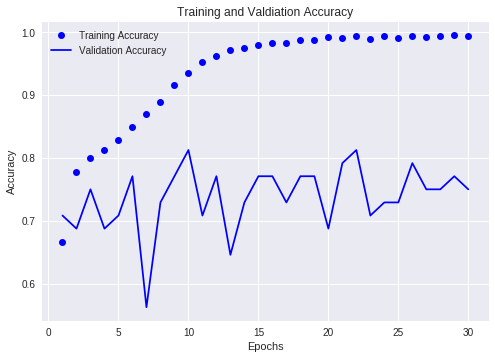

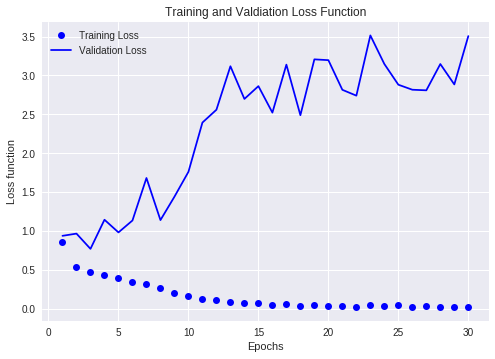

In [92]:
import matplotlib.pyplot as plt

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs1 = range(1, 30 +1)

plt.plot(epochs1, acc1, 'bo', label='Training Accuracy')
plt.plot(epochs1, val_acc1, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdiation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs1, loss1, 'bo', label='Training Loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Training and Valdiation Loss Function')
plt.legend()

plt.show()

In [9]:
from keras import models
from keras import layers
from keras import optimizers

trainGen2 = trainDatagen.flow_from_directory(train_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical') 
valGen2 = testDatagen.flow_from_directory(val_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical') 
testGen2 = testDatagen.flow_from_directory(test_dir, target_size = (500, 500),
                                            batch_size = 32, class_mode = 'categorical')

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(500,500,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()
model2.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss = 'categorical_crossentropy', metrics=['acc'])
history2 = model2.fit_generator(trainGen2, steps_per_epoch = 163, epochs = 30, validation_data=valGen2, validation_steps = 50)

Found 5216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 592 images belonging to 3 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 498, 498, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 247, 247, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 128)       0         
___________________

163/163 [==============================] - 127s 779ms/step - loss: 0.7651 - acc: 0.6931 - val_loss: 1.1518 - val_acc: 0.4375
Epoch 2/30
163/163 [==============================] - 122s 750ms/step - loss: 0.4910 - acc: 0.7824 - val_loss: 0.9977 - val_acc: 0.6458
Epoch 3/30
155/163 [===========================>..] - ETA: 4s - loss: 0.4389 - acc: 0.8075

163/163 [==============================] - 122s 750ms/step - loss: 0.4408 - acc: 0.8069 - val_loss: 0.8489 - val_acc: 0.6667
Epoch 4/30
163/163 [==============================] - 123s 752ms/step - loss: 0.3971 - acc: 0.8232 - val_loss: 1.4275 - val_acc: 0.5833
Epoch 5/30
163/163 [==============================] - 122s 750ms/step - loss: 0.3587 - acc: 0.8461 - val_loss: 0.8781 - val_acc: 0.7292
Epoch 6/30
 11/163 [=>............................] - ETA: 1:33 - loss: 0.3098 - acc: 0.8778

163/163 [==============================] - 121s 745ms/step - loss: 0.3264 - acc: 0.8595 - val_loss: 2.3380 - val_acc: 0.4792
Epoch 7/30
163/163 [==============================] - 122s 748ms/step - loss: 0.2880 - acc: 0.8815 - val_loss: 1.4884 - val_acc: 0.6250
Epoch 8/30
147/163 [==========================>...] - ETA: 9s - loss: 0.2464 - acc: 0.8952 

163/163 [==============================] - 122s 751ms/step - loss: 0.2449 - acc: 0.8957 - val_loss: 1.5282 - val_acc: 0.6667
Epoch 9/30
163/163 [==============================] - 120s 737ms/step - loss: 0.2037 - acc: 0.9143 - val_loss: 1.8021 - val_acc: 0.6875
Epoch 10/30
163/163 [==============================] - 120s 737ms/step - loss: 0.1706 - acc: 0.9296 - val_loss: 2.1919 - val_acc: 0.6042
Epoch 11/30
  9/163 [>.............................] - ETA: 1:34 - loss: 0.1256 - acc: 0.9549

163/163 [==============================] - 122s 750ms/step - loss: 0.1333 - acc: 0.9479 - val_loss: 2.6471 - val_acc: 0.5625
Epoch 12/30
163/163 [==============================] - 122s 748ms/step - loss: 0.1065 - acc: 0.9571 - val_loss: 2.1608 - val_acc: 0.6458
Epoch 13/30
145/163 [=========================>....] - ETA: 11s - loss: 0.0747 - acc: 0.9733

163/163 [==============================] - 122s 750ms/step - loss: 0.0738 - acc: 0.9737 - val_loss: 2.6935 - val_acc: 0.6250
Epoch 14/30
163/163 [==============================] - 122s 748ms/step - loss: 0.0551 - acc: 0.9804 - val_loss: 2.7850 - val_acc: 0.6458
Epoch 15/30
163/163 [==============================] - 122s 749ms/step - loss: 0.0530 - acc: 0.9841 - val_loss: 3.5197 - val_acc: 0.6042
Epoch 16/30
  8/163 [>.............................] - ETA: 1:34 - loss: 0.0309 - acc: 0.9922

163/163 [==============================] - 122s 747ms/step - loss: 0.0432 - acc: 0.9885 - val_loss: 3.0677 - val_acc: 0.6042
Epoch 17/30
163/163 [==============================] - 122s 749ms/step - loss: 0.0338 - acc: 0.9916 - val_loss: 3.2675 - val_acc: 0.6667
Epoch 18/30
145/163 [=========================>....] - ETA: 11s - loss: 0.0283 - acc: 0.9925

163/163 [==============================] - 121s 743ms/step - loss: 0.0255 - acc: 0.9933 - val_loss: 2.9434 - val_acc: 0.6667
Epoch 19/30
163/163 [==============================] - 121s 743ms/step - loss: 0.0403 - acc: 0.9906 - val_loss: 2.4659 - val_acc: 0.6875
Epoch 20/30
163/163 [==============================] - 122s 750ms/step - loss: 0.0313 - acc: 0.9929 - val_loss: 3.5118 - val_acc: 0.6875
Epoch 21/30
  8/163 [>.............................] - ETA: 1:34 - loss: 0.0058 - acc: 0.9961

163/163 [==============================] - 122s 747ms/step - loss: 0.0169 - acc: 0.9952 - val_loss: 3.7180 - val_acc: 0.7083
Epoch 22/30
163/163 [==============================] - 122s 746ms/step - loss: 0.0182 - acc: 0.9950 - val_loss: 3.6911 - val_acc: 0.6875
Epoch 23/30
145/163 [=========================>....] - ETA: 11s - loss: 0.0211 - acc: 0.9950

163/163 [==============================] - 122s 747ms/step - loss: 0.0191 - acc: 0.9956 - val_loss: 3.1202 - val_acc: 0.6458
Epoch 24/30
163/163 [==============================] - 122s 746ms/step - loss: 0.0313 - acc: 0.9958 - val_loss: 3.4213 - val_acc: 0.6458
Epoch 25/30
163/163 [==============================] - 121s 745ms/step - loss: 0.0297 - acc: 0.9950 - val_loss: 3.2806 - val_acc: 0.7292
Epoch 26/30
  8/163 [>.............................] - ETA: 1:37 - loss: 0.0016 - acc: 1.0000

163/163 [==============================] - 122s 748ms/step - loss: 0.0121 - acc: 0.9964 - val_loss: 2.9908 - val_acc: 0.7083
Epoch 27/30
163/163 [==============================] - 121s 742ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 3.6631 - val_acc: 0.6875
Epoch 28/30
143/163 [=========================>....] - ETA: 12s - loss: 0.0160 - acc: 0.9954

163/163 [==============================] - 121s 744ms/step - loss: 0.0141 - acc: 0.9960 - val_loss: 3.4691 - val_acc: 0.6667
Epoch 29/30
163/163 [==============================] - 121s 745ms/step - loss: 0.0344 - acc: 0.9950 - val_loss: 3.5522 - val_acc: 0.6875
Epoch 30/30
163/163 [==============================] - 122s 749ms/step - loss: 0.0238 - acc: 0.9964 - val_loss: 3.5323 - val_acc: 0.6667


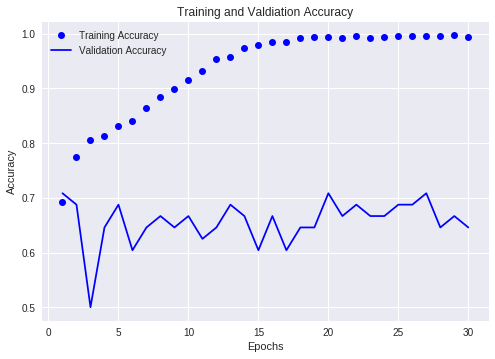

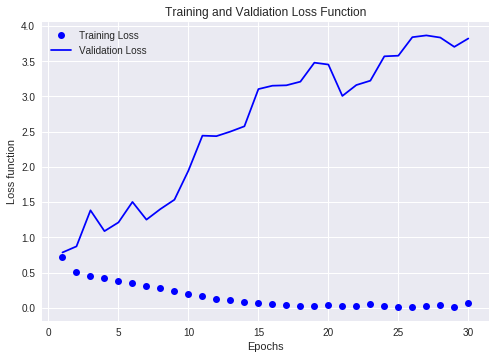

In [96]:
import matplotlib.pyplot as plt

acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, 30 +1)

plt.plot(epochs2, acc2, 'bo', label='Training Accuracy')
plt.plot(epochs2, val_acc2, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdiation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs2, loss2, 'bo', label='Training Loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.title('Training and Valdiation Loss Function')
plt.legend()

plt.show()

In [0]:
from sklearn.model_selection import StratifiedKFold as SKF
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validation_score as CVS

from keras import models
from keras import layers
from keras import optimizers
import numpy as np

def generateModel():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(600, 420, 3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(32, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
  model.summary()
  model.compile(optimizer = optimizers.RMSprop(lr=1e-5), loss = 'categorical_crossentropy', metrics=['acc'])
  return model

skf = SKF(n_splits=3, shuffle=True, random_state=1)
folds = list(skf.split()) 